In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
import copy
import scipy
import scipy.stats

import os, sys

project_root = '/user_data/mmhender/featsynth/'
# sys.path.append(os.path.join(project_root, 'code'))
sys.path.insert(0, os.path.join(project_root, 'code'))
from utils import stats_utils, plot_utils
from behav_analysis import analyze_expt4

figpath = os.path.join(project_root, 'figures_raw')

In [2]:
trial_data_all, subjects, cue_level_names, image_type_names = analyze_expt4.load_data()
 
n_subjects = len(subjects)
n_cue_levels = len(cue_level_names)
n_image_types = len(image_type_names)

acc_by_condition, dprime_by_condition, propleft_by_condition, rt_by_condition = analyze_expt4.get_perf_by_cond()

acc_by_run, dprime_by_run, rt_by_run = analyze_expt4.get_perf_by_run()

acc_by_supcat, dprime_by_supcat, rt_by_supcat = analyze_expt4.get_perf_by_supercateg()

In [3]:
super_names, super_cbinds, basic_names, basic_inds, \
        super_names_long, super_inds_long, n_basic, n_super, n_basic_each_super = \
            analyze_expt4.get_categ_info()

super_names_plot = copy.deepcopy(super_names)
ind = np.where(np.isin(super_names, 'musical_instrument'))[0][0]
super_names_plot[ind] = 'instrument'

super_names, super_names_plot

(['insect',
  'mammal',
  'vegetable',
  'fruit',
  'tool',
  'musical_instrument',
  'furniture',
  'vehicle'],
 ['insect',
  'mammal',
  'vegetable',
  'fruit',
  'tool',
  'instrument',
  'furniture',
  'vehicle'])

#### Compare trials where target/distractor were natural/artificial

In [4]:
is_natural = np.array([1,1,1,1,0,0,0,0]).astype(bool)
kind_names = ['Artificial','Natural']
n_kinds = len(kind_names)

art_super = np.array(super_names)[~is_natural]
nat_super = np.array(super_names)[is_natural]

art_super, nat_super

(array(['tool', 'musical_instrument', 'furniture', 'vehicle'], dtype='<U18'),
 array(['insect', 'mammal', 'vegetable', 'fruit'], dtype='<U18'))

In [5]:
super_dprime_within_across_nat = np.full(fill_value=0.0, shape=(n_subjects, 2, n_image_types))

for si, ss in enumerate(subjects):

    trial_data = trial_data_all[trial_data_all['subject']==ss]

    nat = is_natural[np.array(trial_data['categ_ind']).astype(int)]
    
    for ii, imtype in enumerate(image_type_names):

        # want superordinate task only, this image type
        inds = (trial_data['cue_level']=='super') & \
                (trial_data['image_type']==imtype)

        # grouping by target/distractor combinations
        inds1 = inds & (np.isin(trial_data['super_name'], nat_super)) & \
                        (np.isin(trial_data['distractor_name'], nat_super))

        inds2 = inds & (np.isin(trial_data['super_name'], art_super)) & \
                        (np.isin(trial_data['distractor_name'],art_super))

        inds3 = inds & (np.isin(trial_data['super_name'], nat_super)) & \
                        (np.isin(trial_data['distractor_name'], art_super))

        inds4 = inds & (np.isin(trial_data['super_name'], art_super)) & \
                        (np.isin(trial_data['distractor_name'], nat_super))

        # print(np.sum(inds1), np.sum(inds2), np.sum(inds3), np.sum(inds4))

        # get all trials where target/distractor were either same/different
        # in terms of natural/artificial status
        same = inds1 | inds2
        diff = inds3 | inds4

        for xx, inds_use in enumerate([same, diff]):
            
            predlabs = np.array(trial_data['resp'])[inds_use]
            reallabs = np.array(trial_data['correct_resp'])[inds_use]
    
            did_respond = predlabs>-1
    
            predlabs = predlabs[did_respond]
            reallabs = reallabs[did_respond]
            
            super_dprime_within_across_nat[si, xx, ii] = stats_utils.get_dprime(predlabs, reallabs)
    

#### d-prime values: two-way repeated measures anova, all subjects

In [6]:
vals = super_dprime_within_across_nat

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['same_diff','image_type'])

print(aov_table)

# then pairwise t-tests (same vs diff)
result = scipy.stats.ttest_rel(vals[:,1,:], vals[:,0,:], axis=0, alternative='two-sided')
tvals = result.statistic
pvals = result.pvalue

df = pd.DataFrame(index=image_type_names)
df['t (same - diff)'] = tvals.round(4)
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr

df


All subjects:
(30, 2, 5)
                         F Value  Num DF  Den DF        Pr > F
same_diff              82.329981     1.0    29.0  5.709647e-10
image_type            148.374254     4.0   116.0  1.197254e-44
same_diff:image_type    1.494034     4.0   116.0  2.085166e-01


,t (same - diff),p
pool1,5.1080,0.000047
pool2,4.7865,0.000077
pool3,3.1103,0.005210
pool4,5.6305,0.000022
orig,1.8570,0.073493


/user_data/mmhender/featsynth/figures_raw/Color_confusions.pdf


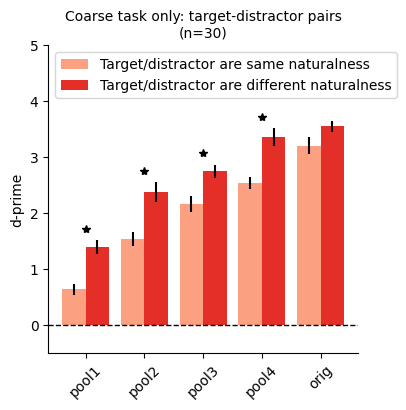

In [8]:
within_across_colors = cm.Reds(np.linspace(0,1,4))[[1,2],:]

xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

plot_utils.set_all_font_sizes(10)
# plt.figure(figsize=(6,4))
plt.figure(figsize=(4,4))

vals = super_dprime_within_across_nat
within_across_names = ['Target/distractor are same naturalness','Target/distractor are different naturalness']

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

lh = []

for ii in range(n_image_types):
    
    for xx, name in enumerate(within_across_names):
    
        h = plt.bar(ii+xjitters[xx], \
                         meanvals[xx,ii], \
                        color = within_across_colors[xx,:], width=barwidth, zorder=0)
        
        plt.errorbar(ii+xjitters[xx], \
                         meanvals[xx,ii], \
                         semvals[xx,ii], \
                        color = 'k',
                        linestyle='none', \
                     # capsize=3, 
                     zorder=10)

        # plt.plot((ii+xjitters[cc]) * np.ones([n_subs_plot,]), \
        #          vals[:,cc,ii], '.', color=[0.8,0.8,0.8], zorder=5)
    
        lh.append(h)

    # for ss in range(n_subs_plot):
            
    #     plt.plot(ii+xjitters, vals[ss,:,ii], '-', color=[0.8,0.8,0.8], zorder=5)
        

    if pvals_fdr[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
        plt.plot(ii, height, '*', color='k', zorder=20)

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

plt.axhline(0.0, color='k',
            # color=[0.8, 0.8, 0.8],
            linestyle='--', linewidth=1)

ax.legend(lh, within_across_names, loc='upper left')

plt.ylabel('d-prime')

plt.ylim([-.5, 5.0])
# assert(np.all(vals<5.0))
# assert(np.all(vals>-0.5))

plt.title('Coarse task only: target-distractor pairs\n(n=%d)'%(n_subs_plot));

savename = os.path.join(figpath, 'Color_confusions.pdf')
print(savename)
plt.savefig(savename, transparent=True)

In [9]:
# these will be combined across all subjects (bc we don't have enough trials)
super_dprime_categ_pairs = np.full(fill_value=0.0, shape=(n_image_types, n_super, n_super))

for ii in range(n_image_types):
    
    for s1 in range(n_super):

        # nan for same category pairs
        super_dprime_categ_pairs[ii,s1,s1] = np.nan
        
        for s2 in range(s1+1, n_super):
            
            inds_use = np.array((trial_data_all['cue_level']=='super') & \
                           (trial_data_all['image_type']==image_type_names[ii]) & \
                           (trial_data_all['super_name']==super_names[s1]) & \
                           (trial_data_all['distractor_name']==super_names[s2]))

            predlabs = np.array(trial_data_all['resp'])[inds_use]
            reallabs = np.array(trial_data_all['correct_resp'])[inds_use]
    
            did_respond = predlabs>-1
    
            predlabs = predlabs[did_respond]
            reallabs = reallabs[did_respond]

            d = stats_utils.get_dprime(predlabs, reallabs)

            # this is diagonally symmetric
            super_dprime_categ_pairs[ii, s1, s2] = d
            super_dprime_categ_pairs[ii, s2, s1] = d
    

/user_data/mmhender/featsynth/figures_raw/Color_confusion_matrix_pool1.pdf


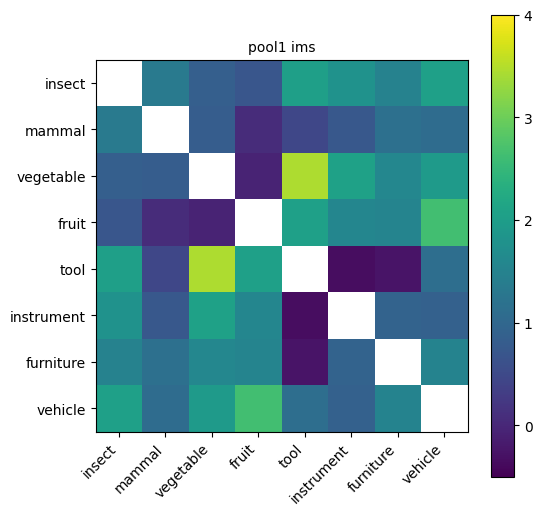

In [23]:

ii = 0;

plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(6,6))

# pi=0;

# for ii in range(n_image_types):

vals = super_dprime_categ_pairs[ii,:]

    # pi+=1
    # plt.subplot(2,3,pi)

plt.pcolormesh(vals, vmin=-0.5, vmax=4.0)
plt.axis('square')
plt.title('%s ims'%image_type_names[ii])
# if pi>3:
plt.xticks(np.arange(n_super)+0.5, super_names_plot, rotation=45, ha = 'right')
    # plt.xlabel('distractor categ')
# else:
#     plt.xticks(np.arange(n_super)+0.5, [], rotation=45, ha = 'right')
# if np.mod(pi, 3)==1:
plt.yticks(np.arange(n_super)+0.5, super_names_plot)
#     # plt.ylabel('actual categ')
# else:
#     plt.yticks(np.arange(n_super)+0.5, [])

plt.gca().invert_yaxis()
# pi=6
# plt.subplot(2,3,pi)
# plt.pcolormesh(np.array([[-0.5, 4.5]]), vmin=-0.5, vmax=4.5)
plt.colorbar(ticks = np.arange(0, 4.1, 1))




savename = os.path.join(figpath, 'Color_confusion_matrix_%s.pdf'%(image_type_names[ii]))
print(savename)
plt.savefig(savename, transparent=True)

# plt.suptitle('Superordinate task only: d-prime for different pairs of categories')

In [49]:
vals1 = np.nanmean(np.reshape(super_dprime_categ_pairs[:,0:4,:][:,:,0:4], [n_image_types, 16]), axis=1)

In [50]:
vals2 = np.nanmean(np.reshape(super_dprime_categ_pairs[:,0:4,:][:,:,4:8], [n_image_types, 16]), axis=1)

(-0.5, 5.0)

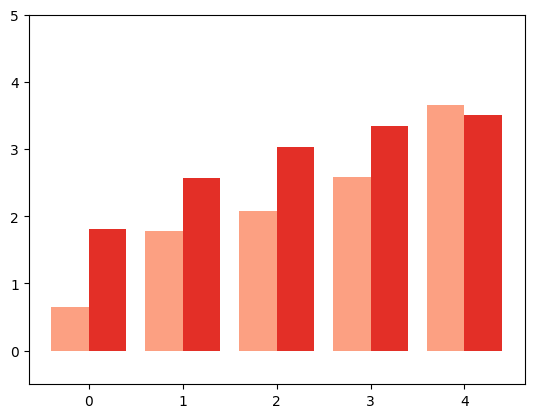

In [52]:

for ii in range(n_image_types):
    
    for xx, vals in enumerate([vals1, vals2]):
    
        h = plt.bar(ii+xjitters[xx], \
                         vals[ii], \
                        color = within_across_colors[xx,:], width=barwidth, zorder=0)
plt.ylim([-0.5, 5.0])

In [16]:
np.nanmax(vals)

3.441469275787305

In [17]:
np.nanmin(vals)

-0.3487556955170447

Text(0.5, 0.98, 'Superordinate task only: d-prime for different pairs of categories')

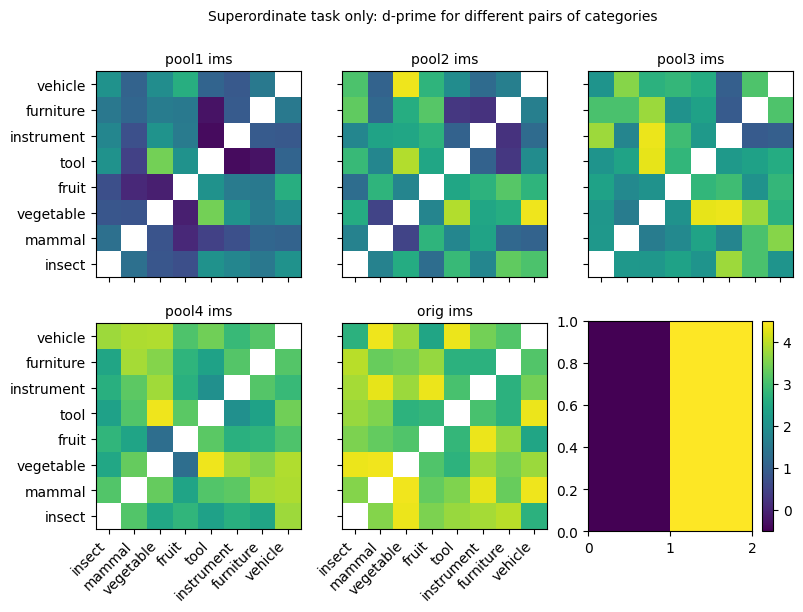

In [18]:

plt.figure(figsize=(9,6))

pi=0;

for ii in range(n_image_types):

    vals = super_dprime_categ_pairs[ii,:]

    pi+=1
    plt.subplot(2,3,pi)
    
    plt.pcolormesh(vals, vmin=-0.5, vmax=4.5)
    plt.axis('square')
    plt.title('%s ims'%image_type_names[ii])
    if pi>3:
        plt.xticks(np.arange(n_super)+0.5, super_names_plot, rotation=45, ha = 'right')
        # plt.xlabel('distractor categ')
    else:
        plt.xticks(np.arange(n_super)+0.5, [], rotation=45, ha = 'right')
    if np.mod(pi, 3)==1:
        plt.yticks(np.arange(n_super)+0.5, super_names_plot)
        # plt.ylabel('actual categ')
    else:
        plt.yticks(np.arange(n_super)+0.5, [])

pi=6
plt.subplot(2,3,pi)
plt.pcolormesh(np.array([[-0.5, 4.5]]), vmin=-0.5, vmax=4.5)
plt.colorbar()

plt.suptitle('Superordinate task only: d-prime for different pairs of categories')

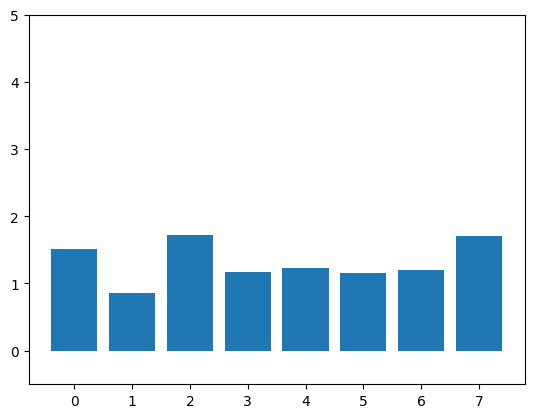

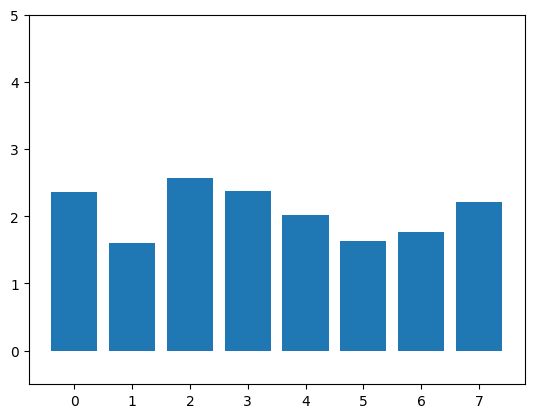

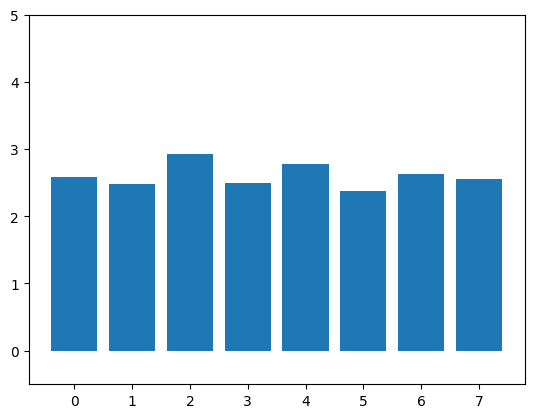

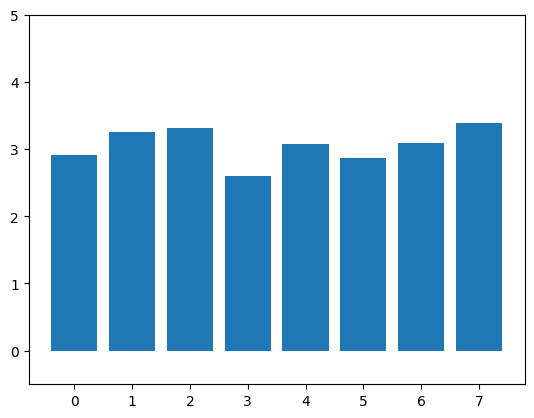

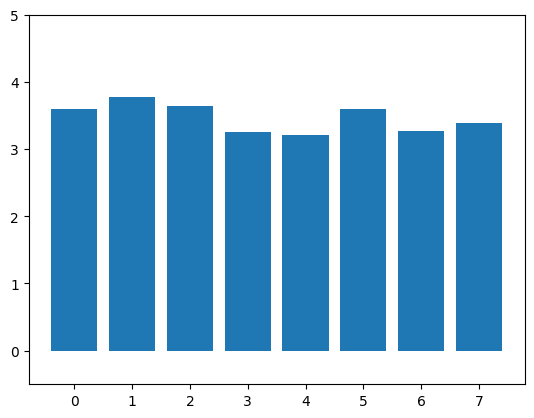

In [41]:
super_dprime_categ_pairs.shape
marginals = np.nanmean(super_dprime_categ_pairs, axis=1)
for ii in range(5):
    plt.figure()
    plt.bar(np.arange(8), marginals[ii,:])
    plt.ylim([-0.5, 5])

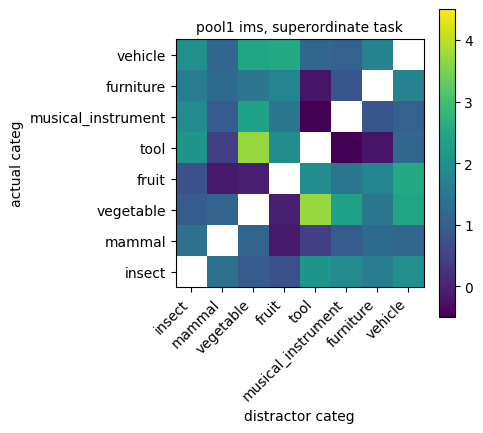

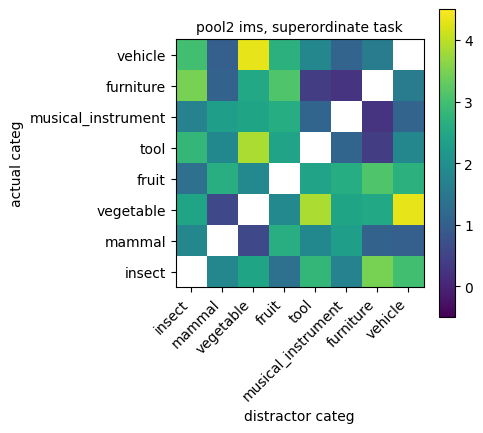

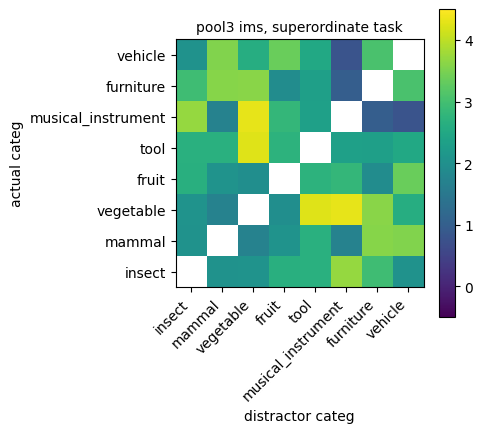

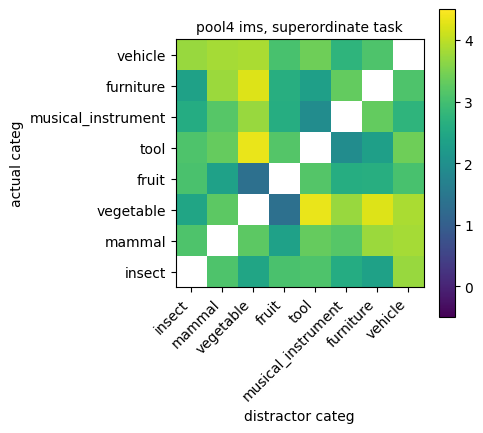

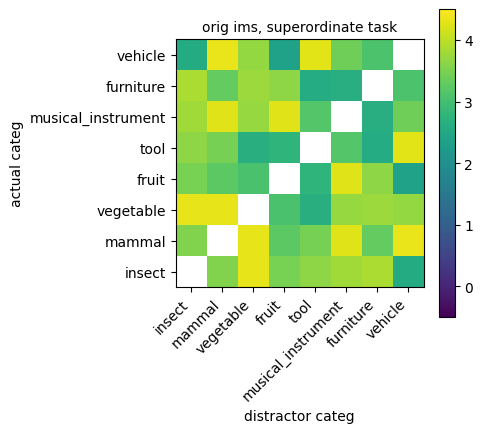

In [167]:

for ii in range(n_image_types):

    vals = super_dprime_categ_pairs[ii,:]
    
    plt.figure(figsize=(4,4))
    plt.pcolormesh(vals, vmin=-0.5, vmax=4.5)
    plt.axis('square')
    plt.title('%s ims, superordinate task'%image_type_names[ii])
    plt.xticks(np.arange(n_super)+0.5, super_names, rotation=45, ha = 'right')
    plt.yticks(np.arange(n_super)+0.5, super_names)
   
    plt.xlabel('distractor categ')
    plt.ylabel('actual categ')
    
    plt.colorbar()

In [165]:
np.nanmin(super_dprime_categ_pairs)

-0.48187908169720683

In [166]:
np.nanmax(super_dprime_categ_pairs)

4.332213505784658

In [139]:
super_confus_total = np.full(fill_value=0.0, shape=(n_image_types, n_super, n_super))
super_confus_correct = np.full(fill_value=0.0, shape=(n_image_types, n_super, n_super))
super_confus_noresp = np.full(fill_value=0.0, shape=(n_image_types, n_super, n_super))

cue_level = 'super'; # super only

for ii in range(n_image_types):
    
    for super_ind_actual in range(n_super):
        
        for super_ind_distract in range(n_super):
            
            if super_ind_actual==super_ind_distract:
                
                super_confus_total[ii, super_ind_actual, super_ind_distract] = np.nan
                super_confus_correct[ii, super_ind_actual, super_ind_distract] = np.nan
                super_confus_noresp[ii, super_ind_actual, super_ind_distract] = np.nan
            
            else:
                inds = np.array((trial_data_all['cue_level']==cue_level) & \
                           (trial_data_all['image_type']==image_type_names[ii]) & \
                           (trial_data_all['super_name']==super_names[super_ind_actual]) & \
                           (trial_data_all['distractor_name']==super_names[super_ind_distract]))

                tot = np.sum(inds)
                correct = np.sum(np.array(trial_data_all['correct'])[inds])
                noresp = np.sum(np.isnan(np.array(trial_data_all['rt'])[inds]))

                super_confus_total[ii, super_ind_actual, super_ind_distract] += tot
                super_confus_correct[ii, super_ind_actual, super_ind_distract] += correct
                super_confus_noresp[ii, super_ind_actual, super_ind_distract] += noresp

In [140]:
prop_correct = super_confus_correct / super_confus_total

In [80]:
is_natural = np.array([1,1,1,1,0,0,0,0]).astype(bool)
kind_names = ['Artificial','Natural']
n_kinds = len(kind_names)

within_natural_props = np.zeros([n_image_types, n_kinds*n_kinds])


for ii in range(n_image_types):

    names = []
    xx = -1
    for kk1 in range(n_kinds):
        for kk2 in range(n_kinds):
            
            inds1 = (is_natural==kk1)
            inds2 = (is_natural==kk2)

            names += ['Actual %s, Distractor %s'%(kind_names[kk1], kind_names[kk2])]

            prop_vals = prop_correct[ii,inds1,:][:,inds2]

            xx+=1
            within_natural_props[ii,xx] = np.nanmean(prop_vals)
    

In [82]:
within_natural_props

array([[0.59289501, 0.67329962, 0.79532819, 0.64410296],
       [0.68615369, 0.83058701, 0.86832317, 0.81946322],
       [0.79376207, 0.8871939 , 0.91467823, 0.86495444],
       [0.88075151, 0.92215528, 0.94285531, 0.87190564],
       [0.9195089 , 0.9463186 , 0.95720774, 0.94977002]])

In [79]:
plt.

['Actual Artificial, Distractor Artificial',
 'Actual Artificial, Distractor Natural',
 'Actual Natural, Distractor Artificial',
 'Actual Natural, Distractor Natural']

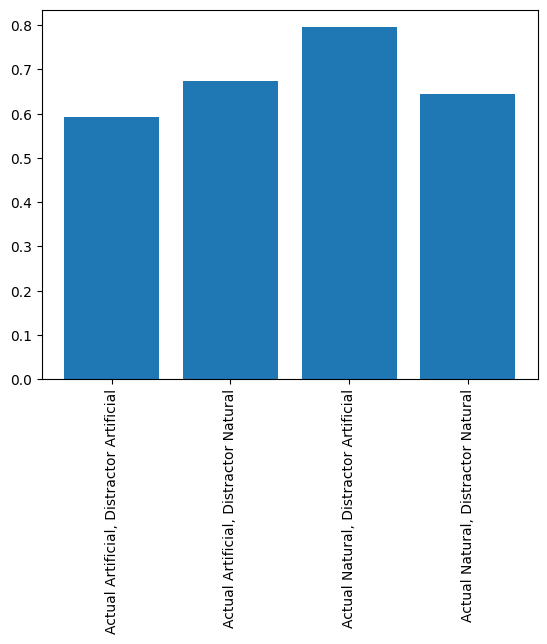

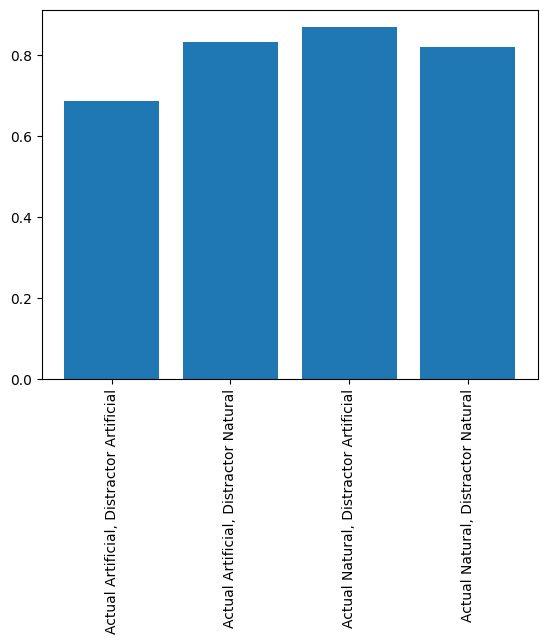

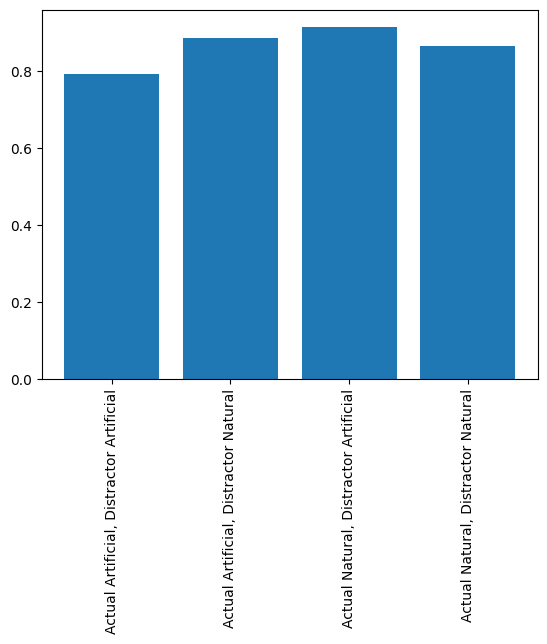

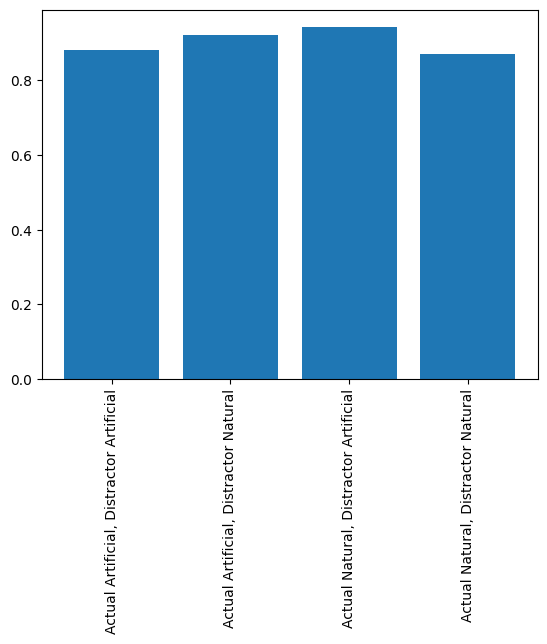

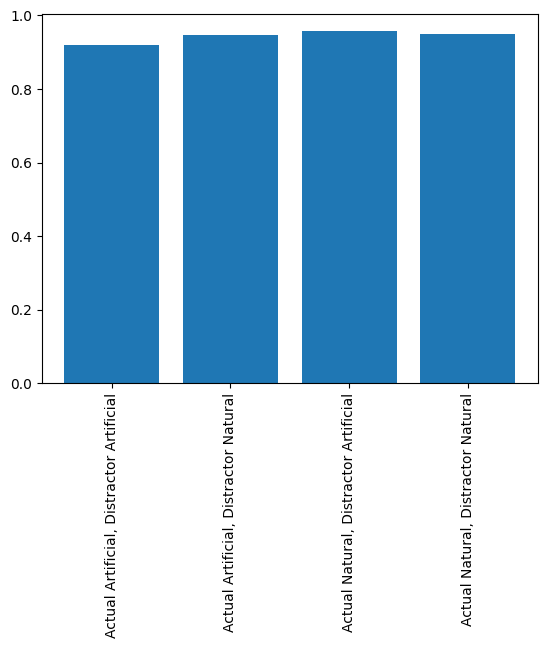

In [86]:
vals = within_natural_props

for ii in range(n_image_types):
    plt.figure()
    plt.bar(np.arange(vals.shape[1]), vals[ii,:])
    plt.xticks(np.arange(vals.shape[1]), names, rotation=90)

In [148]:
def make_symmetric(p, diag_val=0):

    p_symmetric = np.zeros_like(p)
    for a in np.arange(p.shape[0]):
        p_symmetric[a,a] = diag_val
        for b in np.arange(a+1, p.shape[0]):
            m = np.mean([p[a,b], p[b,a]])
            p_symmetric[a,b] = m
            p_symmetric[b,a] = m

    return p_symmetric

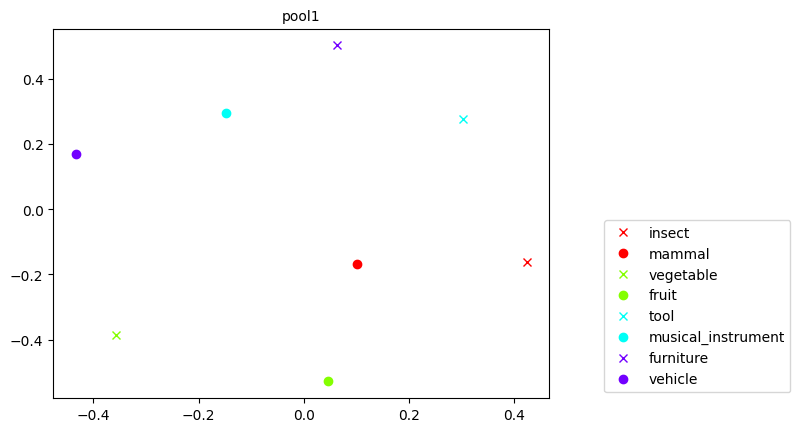

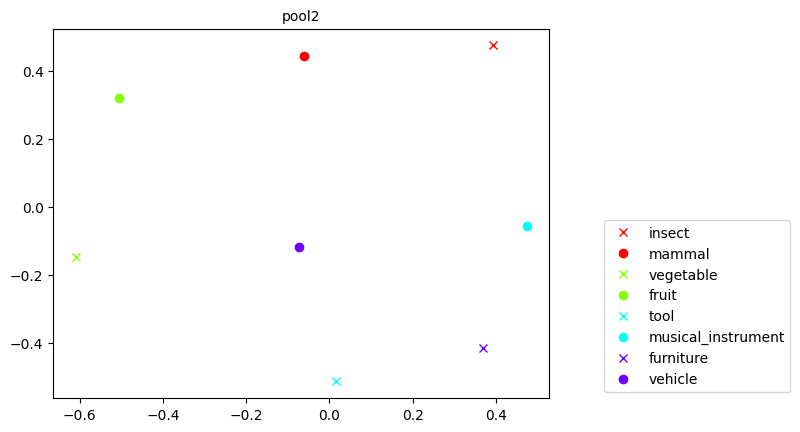

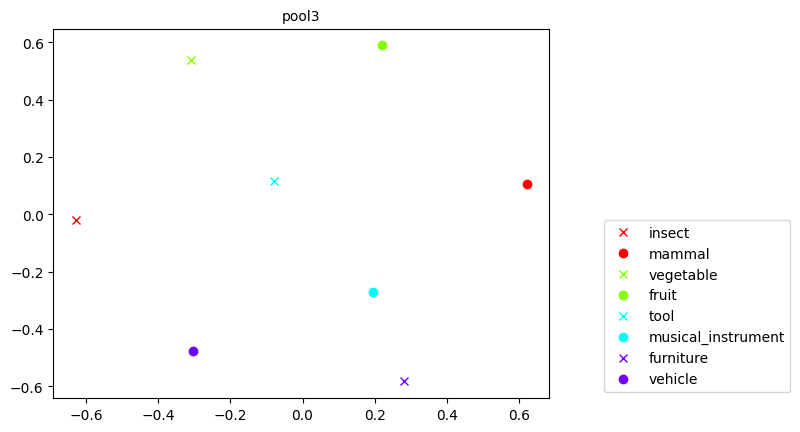

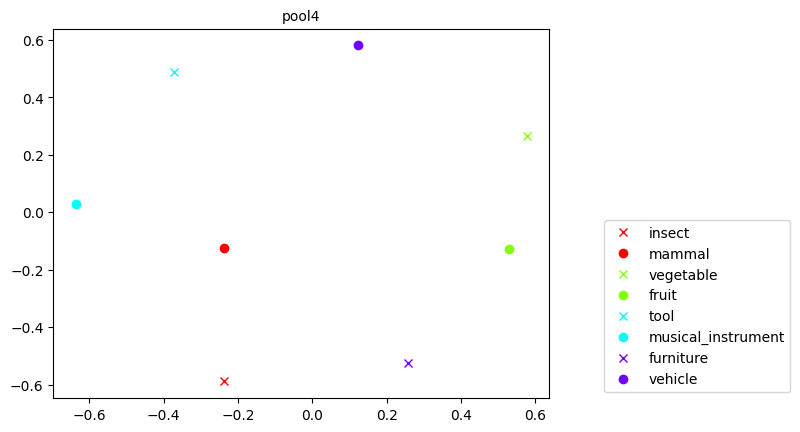

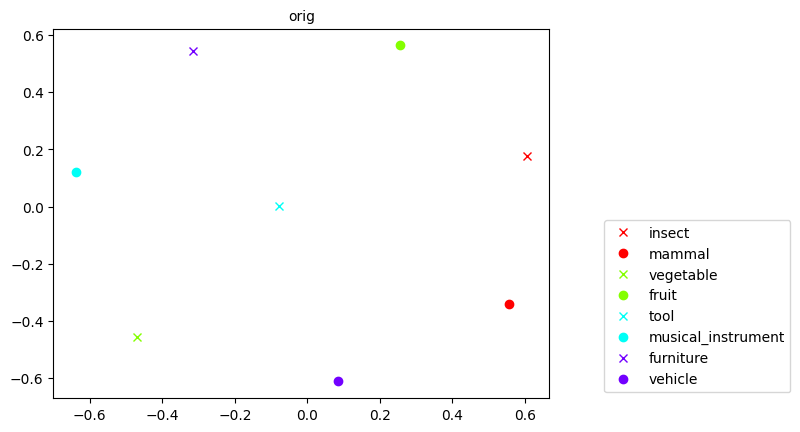

In [156]:
import sklearn.manifold

for ii in range(5):
    
    prop_correct = super_confus_correct / super_confus_total

    p = prop_correct[ii,:,:]
    p_symmetric = make_symmetric(p, 0)
    
            
    mds = sklearn.manifold.MDS(metric=True, dissimilarity = 'precomputed', \
                               normalized_stress = 'auto')
    mds.fit(p_symmetric)
    
    e = mds.embedding_
    colors = cm.hsv(np.linspace(0,1,5))[0:4,:]
    colors = np.repeat(colors, axis=0, repeats = 2)
    types = np.tile(np.array(['x', 'o']), 4)
    plt.figure()
    for xx in range(e.shape[0]):
        plt.plot(e[xx,0], e[xx,1], types[xx], color=colors[xx,:])
        plt.legend(super_names, bbox_to_anchor=(1, 0., 0.5, 0.5))


    plt.title(image_type_names[ii])

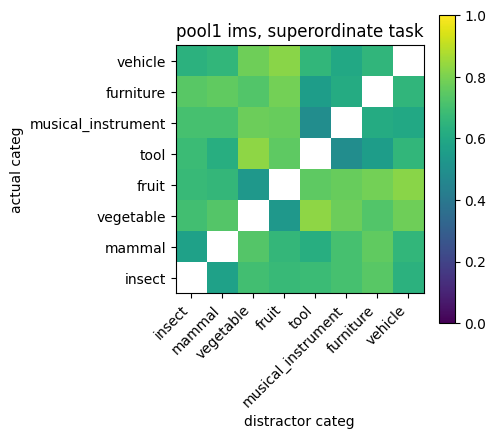

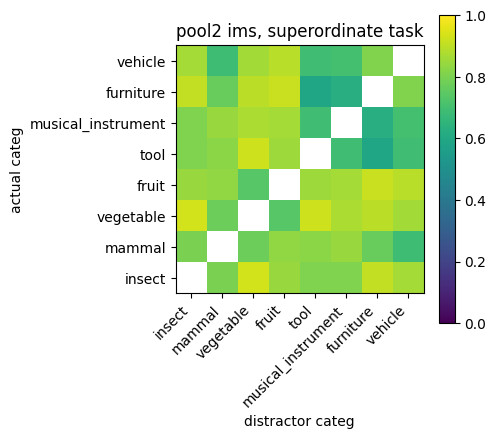

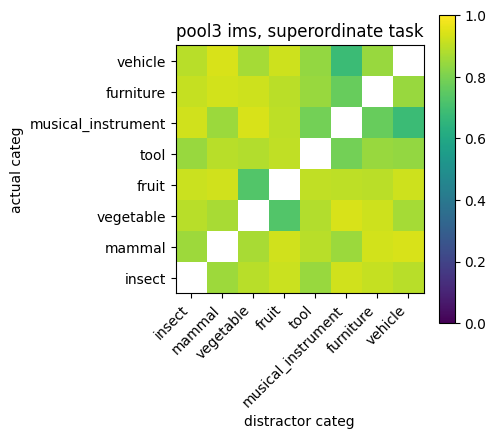

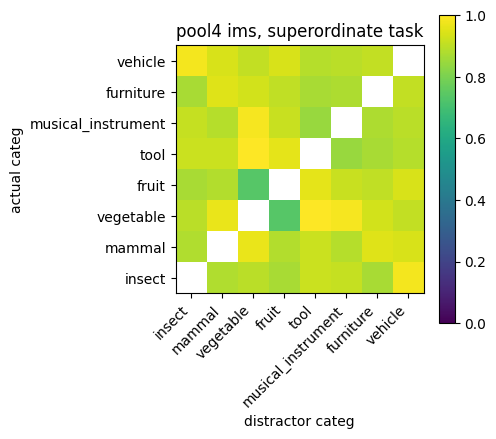

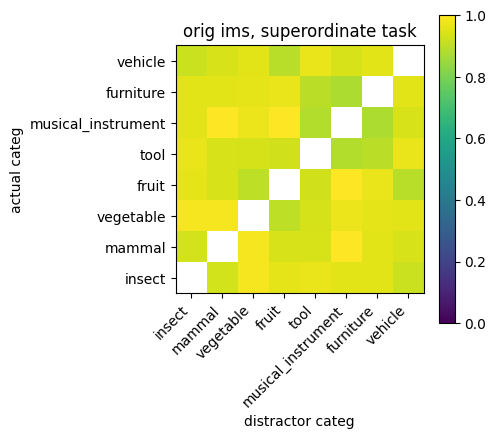

In [55]:
prop_correct = super_confus_correct / super_confus_total

# plt.figure(figsize=(12,8))

for ii in range(n_image_types):

    p = prop_correct[ii,:,:]
    p_symmetric = np.zeros_like(p)
    for a in np.arange(p.shape[0]):
        p_symmetric[a,a] = np.nan
        for b in np.arange(a+1, p.shape[0]):
            m = np.mean([p[a,b], p[b,a]])
            p_symmetric[a,b] = m
            p_symmetric[b,a] = m
      
    
    plt.figure(figsize=(4,4))
    # plt.subplot(2,3,ii+1)
    # plt.pcolormesh(prop_correct[ii,:,:], vmin=0, vmax=1.0)
    plt.pcolormesh(p_symmetric, vmin=0, vmax=1.0)
    plt.axis('square')
    plt.title('%s ims, superordinate task'%image_type_names[ii])
    plt.xticks(np.arange(n_super)+0.5, super_names, rotation=45, ha = 'right')
    plt.yticks(np.arange(n_super)+0.5, super_names)
   
    plt.xlabel('distractor categ')
    plt.ylabel('actual categ')
    
    plt.colorbar()

In [12]:
basic_confus_total = np.full(fill_value=0.0, shape=(n_image_types, n_super, n_basic_each_super, n_basic_each_super))
basic_confus_correct = np.full(fill_value=0.0, shape=(n_image_types, n_super, n_basic_each_super, n_basic_each_super))
basic_confus_noresp = np.full(fill_value=0.0, shape=(n_image_types, n_super, n_basic_each_super, n_basic_each_super))

cue_level = 'basic'; # basic only

bnames_each = [np.array(basic_names)[super_names_long==super_names[si]] \
              for si in range(n_super)]

for ii in range(n_image_types):
    
    for super_ind_actual in range(n_super):
        
        bnames_here = bnames_each[super_ind_actual]
        
        for bi1, bname1 in enumerate(bnames_here):

            for bi2, bname2 in enumerate(bnames_here):

                if bi1==bi2:

                    basic_confus_total[ii, super_ind_actual, bi1, bi2] = np.nan
                    basic_confus_correct[ii, super_ind_actual, bi1, bi2] = np.nan
                    basic_confus_noresp[ii, super_ind_actual, bi1, bi2] = np.nan

                else:
                    inds = np.array((trial_data_all['cue_level']==cue_level) & \
                               (trial_data_all['image_type']==image_type_names[ii]) & \
                               (trial_data_all['super_name']==super_names[super_ind_actual]) & \
                               (trial_data_all['basic_name']==bname1) & \
                               (trial_data_all['distractor_name']==bname2))

                    tot = np.sum(inds)
                    correct = np.sum(np.array(trial_data_all['correct'])[inds])
                    noresp = np.sum(np.isnan(np.array(trial_data_all['rt'])[inds]))

                    basic_confus_total[ii, super_ind_actual, bi1, bi2] += tot
                    basic_confus_correct[ii, super_ind_actual, bi1, bi2] += correct
                    basic_confus_noresp[ii, super_ind_actual, bi1, bi2] += noresp

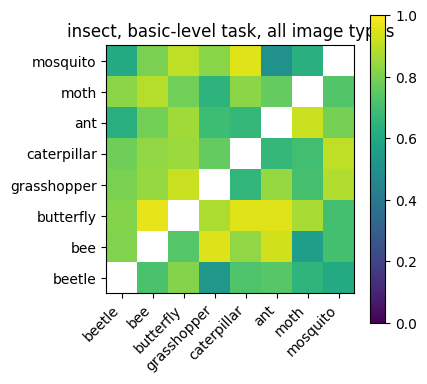

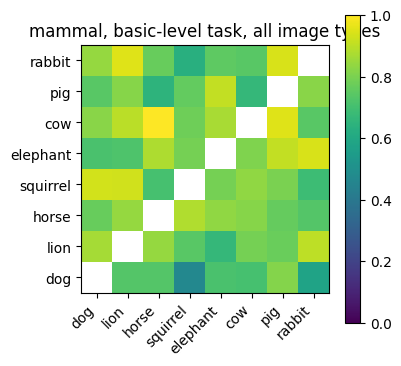

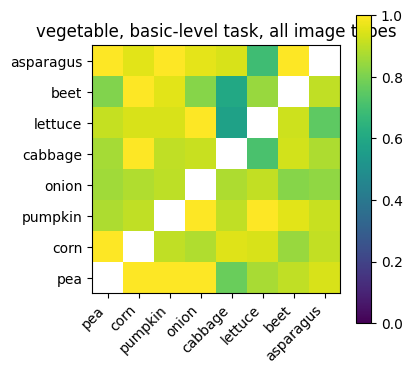

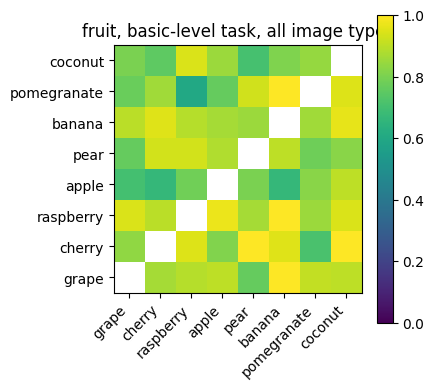

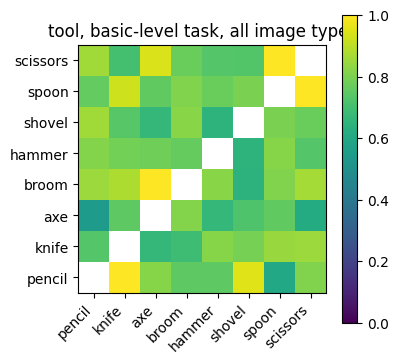

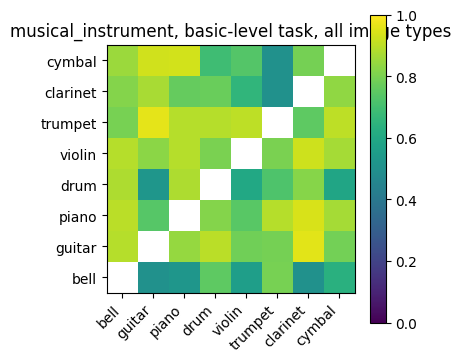

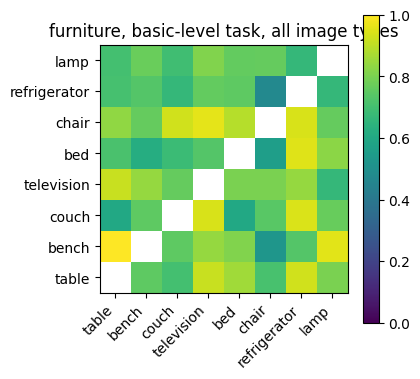

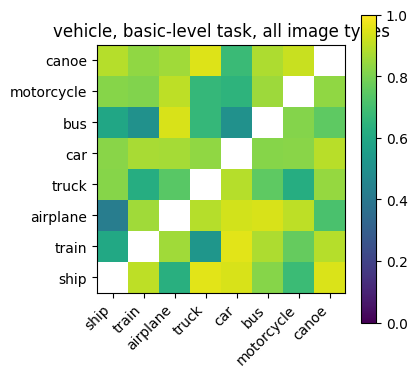

In [13]:
btot = np.sum(basic_confus_total, axis=0)
bcor = np.sum(basic_confus_correct, axis=0)

prop_correct = bcor/btot

# plt.figure(figsize=(12,8))

for super_ind in range(n_super):
    
    plt.figure(figsize=(4,4))
    # plt.subplot(2,3,ii+1)
    plt.pcolormesh(prop_correct[super_ind,:,:], vmin=0, vmax=1.0)
    plt.axis('square')
    plt.title('%s, basic-level task, all image types'%super_names[super_ind])
    
    plt.xticks(np.arange(n_basic_each_super)+0.5, bnames_each[super_ind], rotation=45, ha = 'right')
    plt.yticks(np.arange(n_basic_each_super)+0.5, bnames_each[super_ind])
    
    plt.colorbar()